In [267]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')
#import os
#os.getcwd()
#import sys
#sys.path.append('/Users/alex/Desktop/Columbia/Ken Miller/Codes/SSB/OrientationSSB/')

In [270]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.signal import convolve2d
from copy import copy

from math import floor, ceil

import numpy as np
import tensorflow as tf
import logging
from scipy import linalg

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf

import pickle

import dev_ori_sel_RF 

from dev_ori_sel_RF.tools import gen_gaussian_random_field as ggrf
import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,integrator_tf,dynamics,network,run_onelayer,run_full_plastic,probe_RFs,plasticity_dynamics
from dev_ori_sel_RF.tools import misc,update_params_dict,analysis_tools

Default GPU Device: /device:GPU:0


In [265]:
import os
os.getcwd()

'/Users/alex/Desktop/Columbia/Ken Miller/Codes/SSB/OrientationSSB/notebooks'

In [95]:
#tf.size(st1).numpy()
#tf.sparse.concat(axis=0,[tf.sparse.reshape(st1,[tf.size(st1).numpy()]),tf.sparse.reshape(st1,[tf.size(st1).numpy()])])
#tf.sparse.concat(0,[st1,tf.sparse.to_dense(st1)])
r = tf.random.uniform([2], minval=0, maxval=1, dtype=tf.float64)
st2 = tf.sparse.SparseTensor(st1.indices,r,st1.dense_shape)
tf.sparse.concat(0,[st1,tf.cast(st2,tf.float32)])

SparseTensor(indices=tf.Tensor(
[[0 3]
 [2 4]
 [3 3]
 [5 4]], shape=(4, 2), dtype=int64), values=tf.Tensor([10.01       20.01        0.8325874   0.06044914], shape=(4,), dtype=float32), dense_shape=tf.Tensor([ 6 10], shape=(2,), dtype=int64))

In [16]:
class Connectivity:
	def __init__(self, from_size, to_size, random_seed, Nvert=1, full_output=False, verbose=True):
		self.from_size = from_size
		self.to_size = to_size
		if isinstance(Nvert,int):
			Nvert = (Nvert,Nvert)
		self.Nvert = Nvert
		self.rng = np.random.RandomState(random_seed*90)
		# self.rng = np.random.default_rng(random_seed*90)
		self.full_output = full_output
		self.full_output_dict = {}
		self.verbose = verbose

In [18]:
import numpy as np
from scipy import linalg
from scipy.signal import convolve2d
from copy import copy

In [ ]:
xto = np.array([[10,20,25],[30,40,45]])
def distance(x,y):
    return abs(x-y)
b=0.1
yto = b*xto
dis = distance(xto[:,:,None,None],yto[None,None,:,:])
#print(dis)
dis.reshape(1)

In [269]:
def get_network_size(config_name):
    config_dict = misc.load_external_params("params_"+config_name)
    config_dict.update({"config_name" : config_name})

    N4 = config_dict["N4"]
    Nlgn = config_dict["Nlgn"]
    Nret = config_dict["Nret"]
    Nlgnpop = 2
    N4pop = config_dict["num_lgn_paths"] // Nlgnpop
    
    return config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4

def get_network_system(Version,config_name):
    if Version == -1:
        config_dict = misc.load_external_params("params_"+config_name,False)
        config_dict.update({
                        "RF_mode" : "initialize",
                        "system" : "one_layer",
                        "Version" : Version,
                        })
        net = network.Network(Version,config_dict,verbose=False)
    else:
        load_location = 'local'
        load_path = data_dir + "layer4/{s}/v{v}/".format(s=config_name,v=Version)
        config_dict = pickle.load(open(load_path + "config_v{v}.p".format(v=Version),"rb"))
        config_dict.update({"config_name" : config_name})
        config_dict["Wlgn_to4_params"].update({
            "W_mode": "load_from_external",
            "load_from_prev_run" : Version})
        net = network.Network(Version,config_dict,load_location=load_location,verbose=False)
    return net.system

In [16]:
reload(plasticity_dynamics)
reload(run_onelayer)
reload(integrator_tf)

config_name = "test1"

config_dict = misc.load_external_params("params_"+config_name)
config_dict.update({"config_name" : config_name})

Version = 0
run_onelayer.parameter_sweep_layer4(Version,config_dict,not_saving_temp=False)

Default GPU Device: /device:GPU:0
MISC params_dict params_test2 {'Nret': 32, 'Nlgn': 32, 'N4': 32, 'N23': 1, 'Nvert': 1, 'runtime': 320, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.01125, 'sigma2': 0.03, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.016875, 'ampl': 1.0, 'profile': 'Gaussian', 'mean

In [12]:
config_dict = misc.load_external_params("params_"+config_name)
config_dict.update({"config_name" : config_name})

config_dict["Wlgn_to4_params"].update({
    "W_mode": "load_from_external",
    "load_from_prev_run" : 0})

reload(network)
reload(run_onelayer)
reload(integrator_tf)
Version = 0
run_onelayer.parameter_sweep_layer4(Version,config_dict,not_saving_temp=False)

MISC params_dict params_test1 {'Nret': 32, 'Nlgn': 32, 'N4': 32, 'N23': 1, 'Nvert': 1, 'runtime': 320, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.01125, 'sigma2': 0.03, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.016875, 'ampl': 1.0, 'profile': 'Gaussian', 'mean_eccentricity': 0.6, 'SD_eccentric

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alex/Desktop/Columbia/Ken Miller/Codes/SSB/OrientationSSB/dev_ori_sel_RF/data/layer4/test1/v1/y_v1.npz'

In [174]:
config_name = "test1"
Version = 8
config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4 = get_network_size(config_name)

MISC params_dict params_test1 {'Nret': 32, 'Nlgn': 32, 'N4': 32, 'N23': 1, 'Nvert': 1, 'runtime': 320, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.01125, 'sigma2': 0.03, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.016875, 'ampl': 1.0, 'profile': 'Gaussian', 'mean_eccentricity': 0.6, 'SD_eccentric

(4, 1024, 1024)


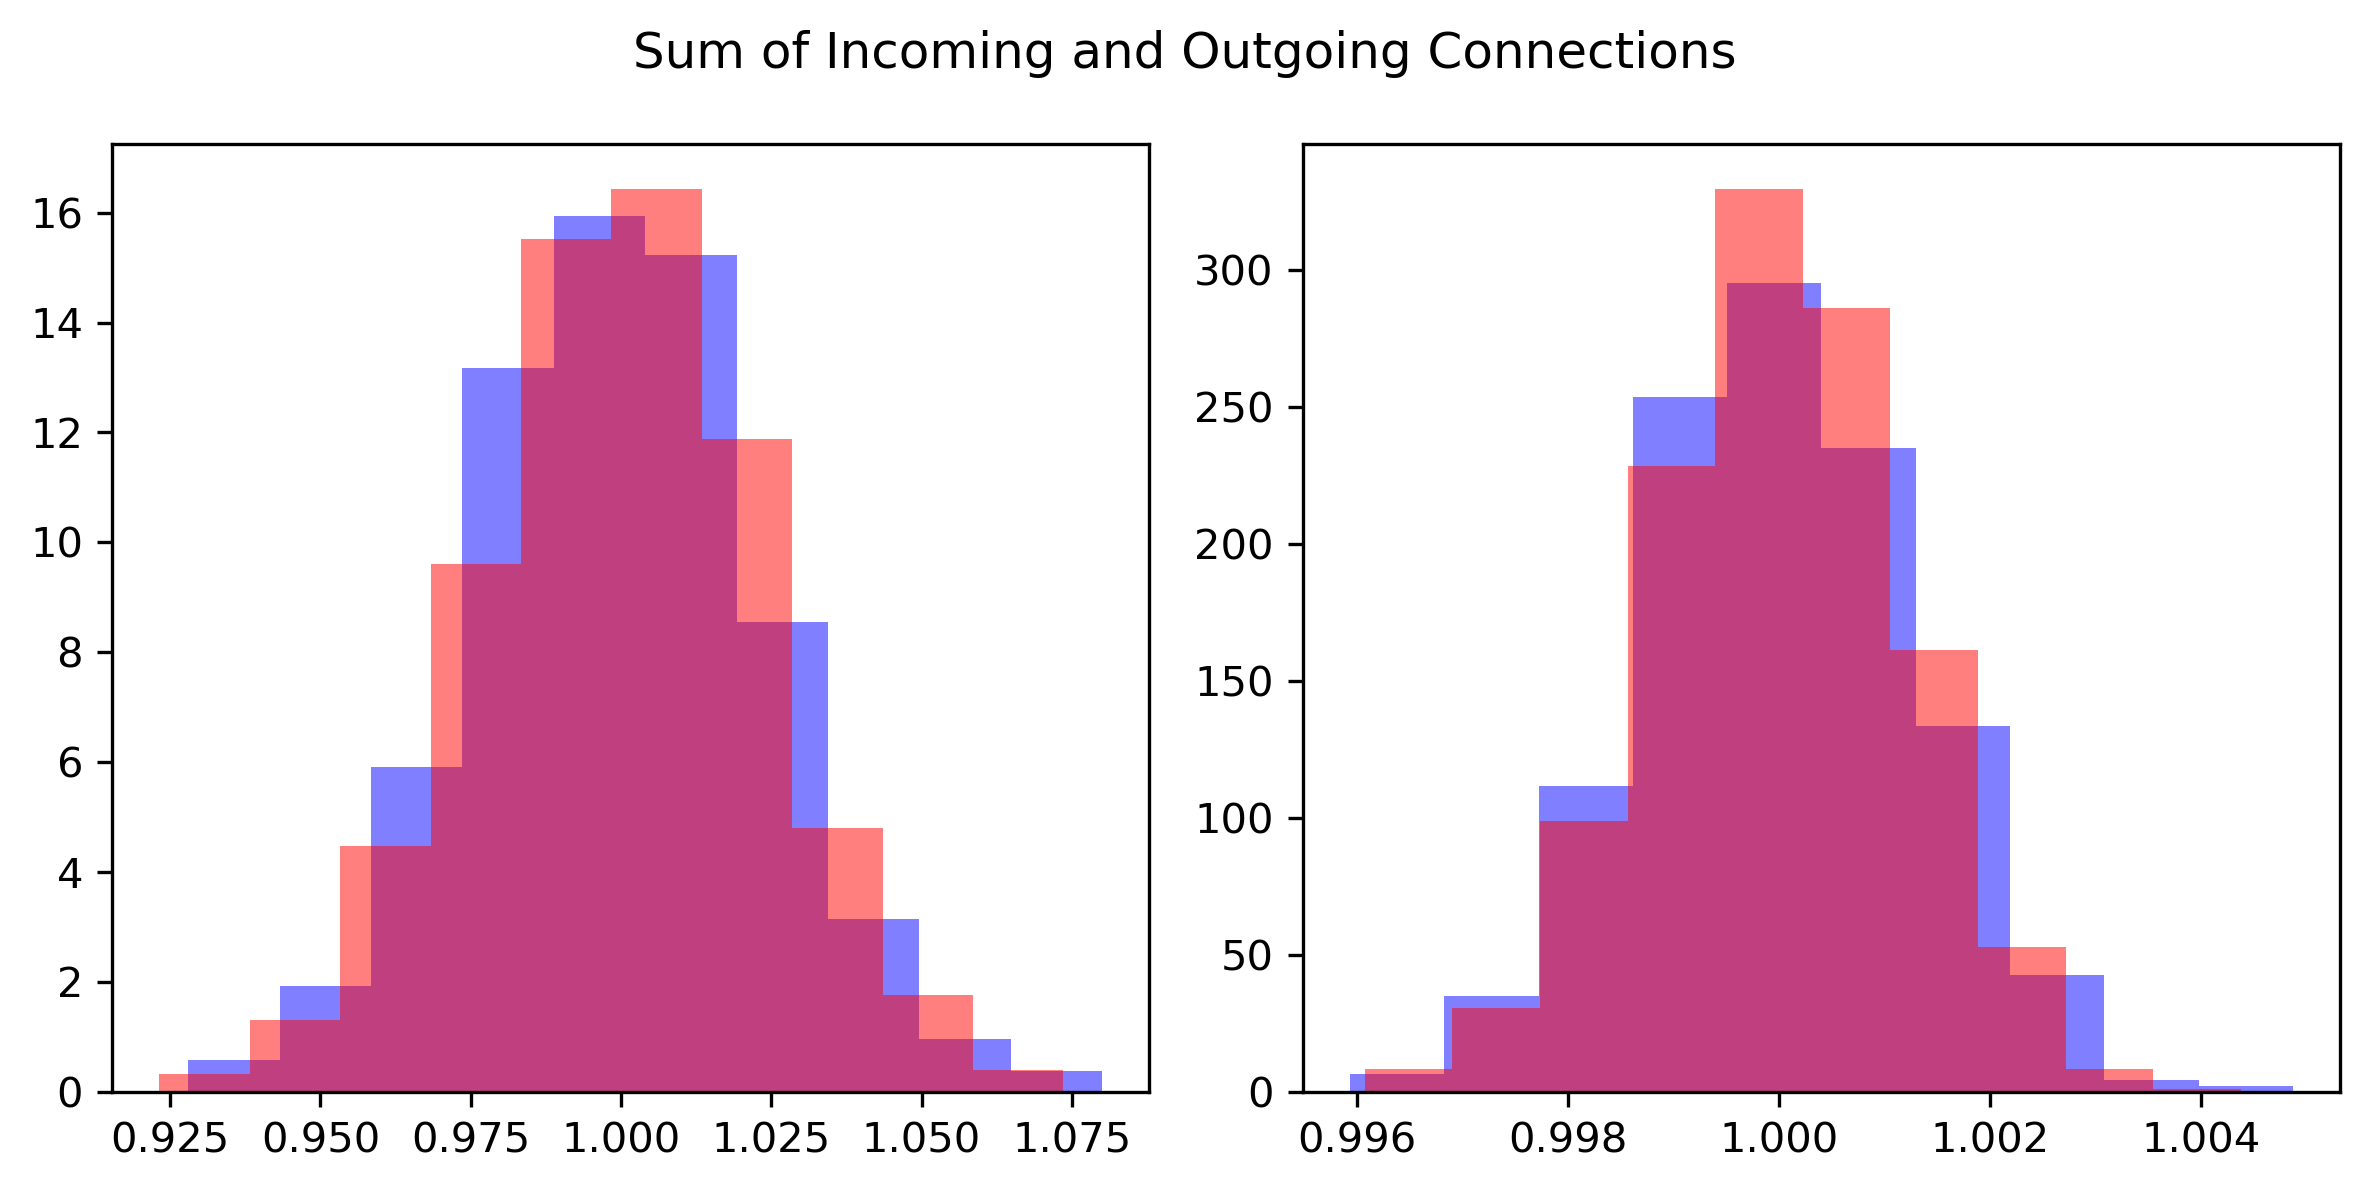

In [183]:
_,Wlgnto4,arbor_on,arbor_off,arbor2,_,W4to4 = get_network_system(Version,config_name)
    
print(Wlgnto4.shape)    
fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)

Wlgnto4.shape
for i in range(2):
    axs[0].hist(Wlgnto4.reshape(N4pop,Nlgnpop,N4,N4,Nlgn,Nlgn)[0,i].reshape(N4**2,Nlgn**2).sum(1),density=True,
                color=['b','r'][i],alpha=0.5)
    axs[1].hist(Wlgnto4.reshape(N4pop,Nlgnpop,N4,N4,Nlgn,Nlgn)[0,i].reshape(N4**2,Nlgn**2).sum(0),density=True,
                color=['b','r'][i],alpha=0.5)
#Wpresum = Wlgnto4.reshape(N4pop,Nlgnpop,N4,N4,Nlgn,Nlgn)[0,:].reshape(Nlgnpop,N4**2,Nlgn**2).sum((0,2))
#axs[0].hist(Wpresum,
 #           bins=np.linspace(np.min(Wpresum)-0.05,np.max(Wpresum)+0.05,11),density=True,color='k',alpha=0.5)

fig.suptitle(r'Sum of Incoming and Outgoing Connections')
fig.tight_layout()

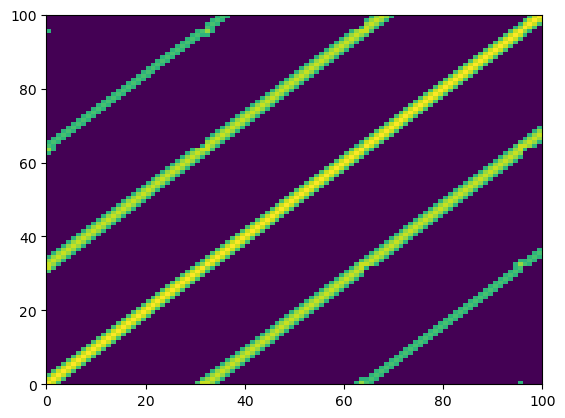

In [185]:
plt.pcolormesh(arbor_on[:100,:100])

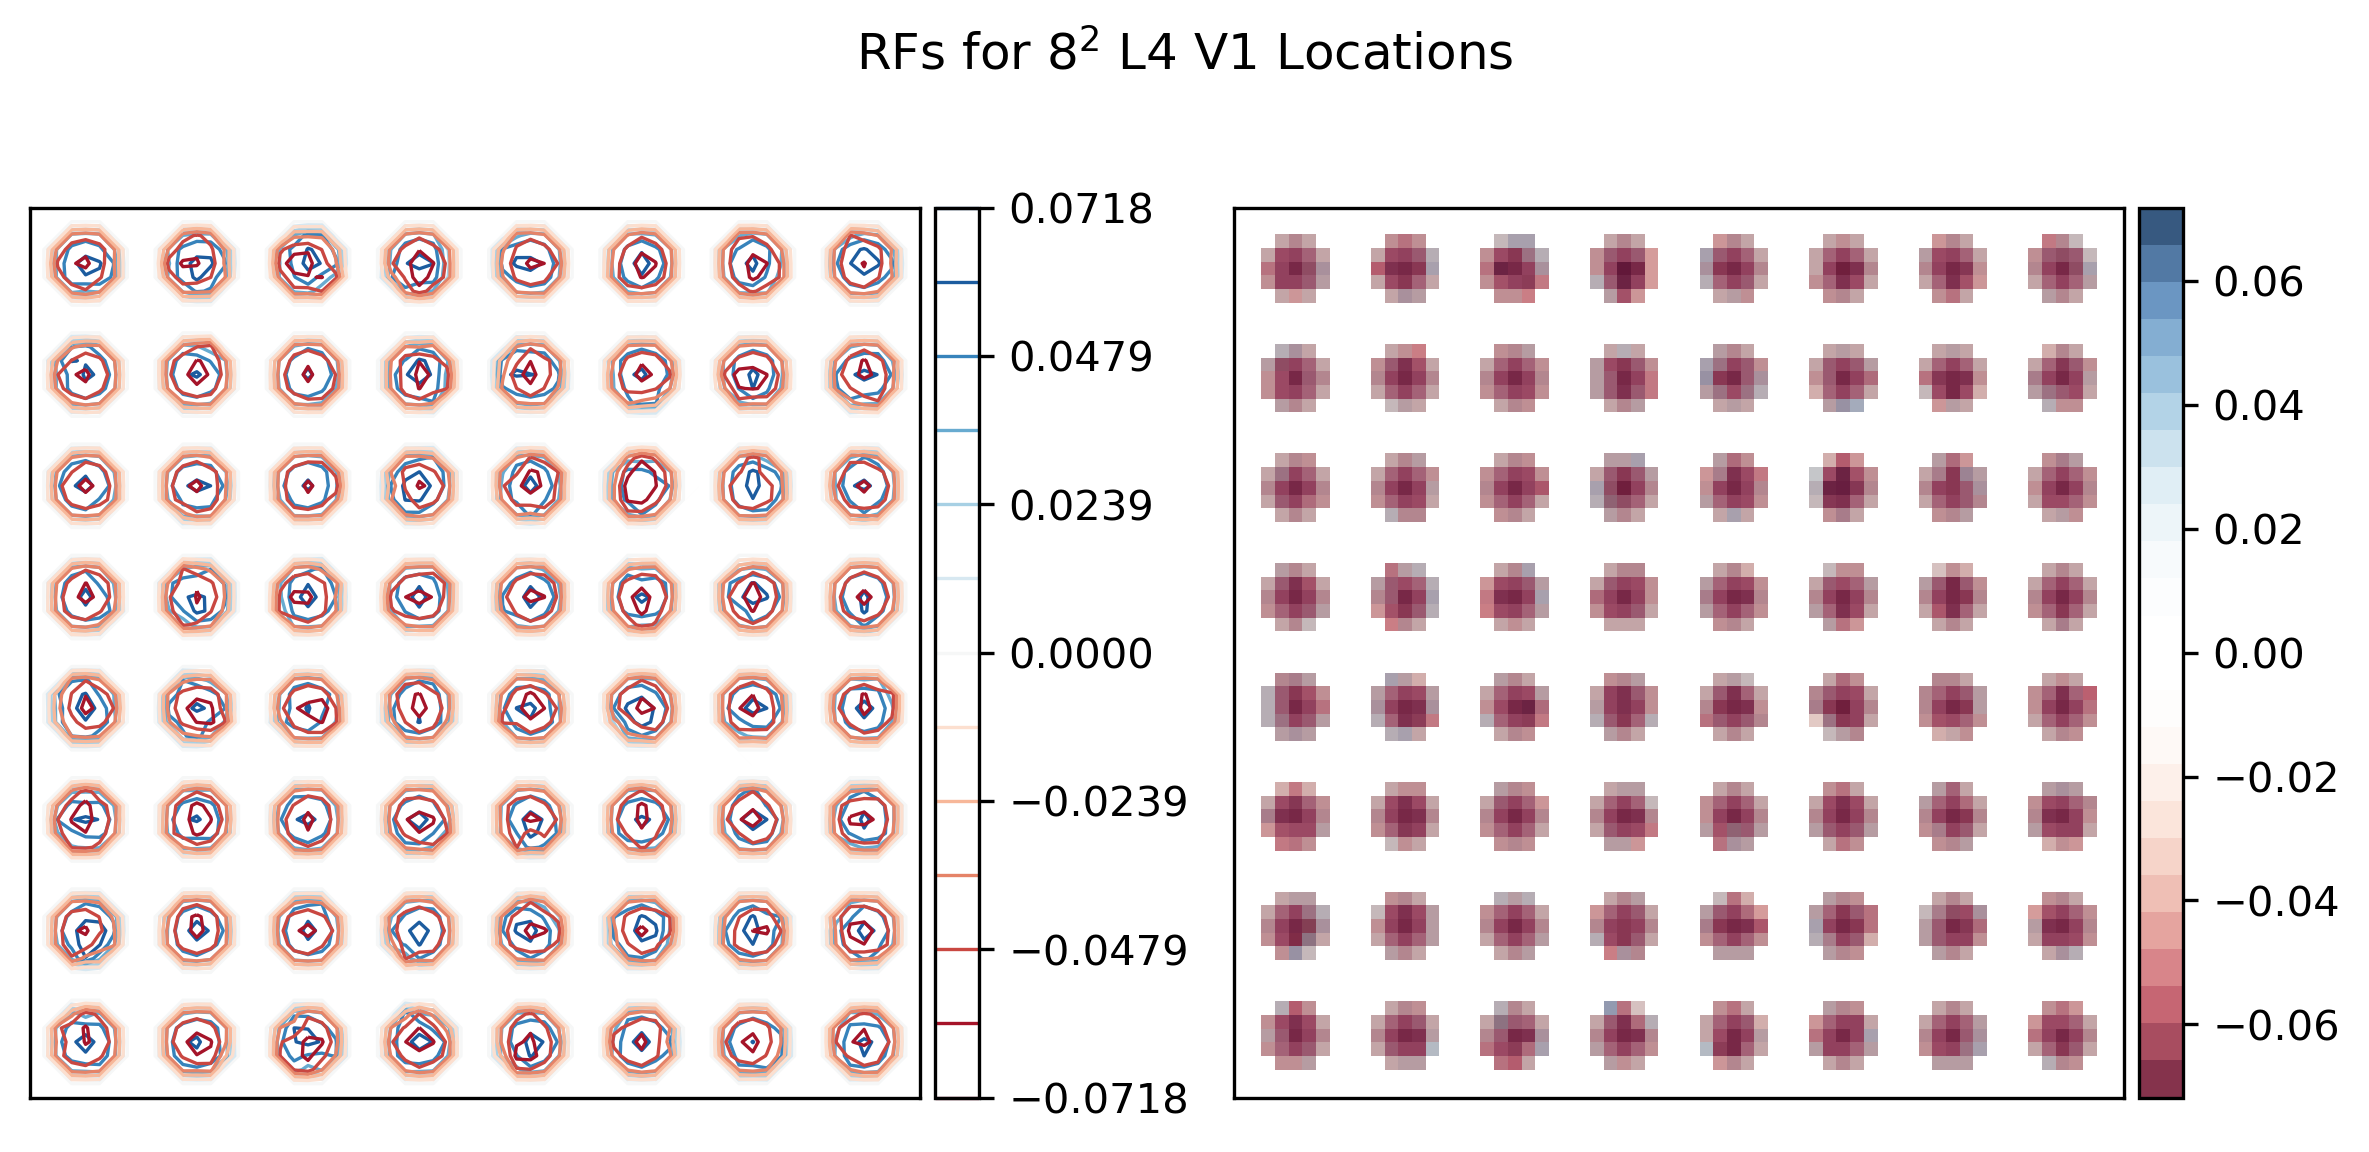

In [192]:
reload(network)
_,Wlgnto4,arbor_on,arbor_off,arbor2,_,W4to4 = get_network_system(Version,config_name)

rA = ceil(config_dict["Wlgn_to4_params"]["r_A_on"] * config_dict["Wlgn_to4_params"].get("r_lim",1.) * N4)
dA = 2*rA+1

idxs = np.arange(N4//16,N4,N4//8)

wff = np.zeros((N4pop,Nlgnpop,len(idxs)*(dA+1)+1,len(idxs)*(dA+1)+1))
for i in range(len(idxs)):
    for j in range(len(idxs)):
        this_wff = Wlgnto4.reshape(N4pop,Nlgnpop,N4,N4,Nlgn,Nlgn)[:,:,idxs[i],idxs[j],:,:]
        wff[:,:,1+i*(dA+1):1+i*(dA+1)+dA,1+j*(dA+1):1+j*(dA+1)+dA] =\
               np.roll(this_wff,(rA-idxs[i],rA-idxs[j]),axis=(-2,-1))[:,:,:dA,:dA]
rf = wff[:,0]-wff[:,1]

fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=300)
fig.subplots_adjust(hspace=.1, wspace=.3)
pf.doubcontbar(fig,axs[0],wff[0,0],-wff[0,1],
               cmap='RdBu',levels=np.linspace(-np.max(np.abs(wff[0])),np.max(np.abs(wff[0])),13),linewidths=0.8)
pf.doubimshbar(fig,axs[1],wff[0,0],-wff[0,1],cmap='RdBu',vmin=-np.max(np.abs(wff[0])),vmax=np.max(np.abs(wff[0])))

fig.suptitle(r'RFs for {:d}$^2$ L4 V1 Locations'.format(len(idxs)))
fig.tight_layout()

In [ ]:
reload(probe_RFs)

config_name = 'lower_wlim'
Version = 31
net,act,phase = probe_RFs.probe_RFs_one_layer(Version,config_name,freqs=Nlgn*np.array([6,7]),Nsur=4)

In [ ]:
def get_ori_sel(opm,calc_fft=True):
    sel = np.abs(opm)
    ori = np.angle(opm)/2
    ori = ori - (np.sign(ori)-1)*0.5*np.pi
    ori *= 180/np.pi
    
    if calc_fft:
        ori_fft = np.abs(np.fft.fftshift(np.fft.fft2(ori - np.nanmean(ori))))
        ori_fps = np.zeros(int(np.ceil(N4//2*np.sqrt(2))))

        grid = np.arange(-N4//2,N4//2)
        x,y = np.meshgrid(grid,grid)
        bin_idxs = np.digitize(np.sqrt(x**2+y**2),np.arange(0,np.ceil(N4//2*np.sqrt(2)))+0.1)
        for idx in range(0,int(np.ceil(N4//2*np.sqrt(2)))):
            ori_fps[idx] = np.mean(ori_fft[bin_idxs == idx])
        
        return ori,sel,ori_fft,ori_fps
    else:
        return ori,sel

maxver = 8
Vers = np.arange(0,maxver+1,np.fmax(1,maxver//8))-1

config_name = 'test'

config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4 = get_network_size(config_name)

oris = np.zeros((len(Vers),N4,N4))
sels = np.zeros((len(Vers),N4,N4))
ori_ffts = np.zeros((len(Vers),N4,N4))
ori_fpss = np.zeros((len(Vers),int(np.ceil(N4//2*np.sqrt(2)))))
seps = np.zeros((len(Vers),N4,N4))
bals = np.zeros((len(Vers),N4,N4))

for idx,Version in enumerate(Vers):
    config_dict = misc.load_external_params("params_"+config_name,False)
    _,Wlgnto4,arbor_on,arbor_off,arbor2,_,W4to4 = get_network_system(Version,config_name)

    ss = Wlgnto4[0,...] + Wlgnto4[1,...]
    sd = Wlgnto4[0,...] - Wlgnto4[1,...]
    ss = ss.reshape((N4,N4,Nlgn,Nlgn))
    sd = sd.reshape((N4,N4,Nlgn,Nlgn))
    rA = np.ceil(config_dict["Wlgn_to4_params"]["r_A_on"] * config_dict["Wlgn_to4_params"].get("r_lim",1.) * N4)
    DA = 2*rA + 5
    opm,Rn = analysis_tools.get_response(sd,DA)
    
    oris[idx],sels[idx],ori_ffts[idx],ori_fpss[idx] = get_ori_sel(opm)
    seps[idx] = np.abs(sd).sum((-2,-1))/ss.sum((-2,-1))
    bals[idx] = 1-np.abs(sd.sum((-2,-1)))/ss.sum((-2,-1))

fig,axs = plt.subplots(10,len(Vers),figsize=(4*len(Vers),4*10),dpi=300,sharex='row',sharey='row')
for i,Version in enumerate(Vers):
    pf.imshowbar(fig,axs[0,i],oris[i],cmap='twilight',vmin=0,vmax=180)
    pf.imshowbar(fig,axs[1,i],sels[i],cmap='binary',vmin=0,vmax=np.max(sels))
    pf.imshowbar(fig,axs[2,i],seps[i],cmap='binary',vmin=0,vmax=1)
    pf.imshowbar(fig,axs[3,i],bals[i],cmap='binary',vmin=0,vmax=1)
    nbin = 20
    def bin_edges(data,nbin):
        return np.linspace(np.min(data),np.max(data),nbin+1)
    axs[4,i].hist(oris[i].flatten(),bin_edges(oris,nbin))
    axs[4,i].axhline(N4*N4/nbin,color='k',ls='--')
    axs[5,i].hist(sels[i].flatten(),bin_edges(sels,nbin))
    axs[5,i].axvline(np.mean(sels[i].flatten()),color='k',ls='--')
    axs[6,i].hist(seps[i].flatten(),bin_edges([0,1],nbin))
    axs[6,i].axvline(np.mean(seps[i].flatten()),color='k',ls='--')
    axs[7,i].hist(bals[i].flatten(),bin_edges([0,1],nbin))
    axs[7,i].axvline(np.mean(bals[i].flatten()),color='k',ls='--')
    
    pf.imshowbar(fig,axs[8,i],ori_ffts[i],cmap='binary',vmin=0,vmax=np.max(ori_ffts))
    axs[9,i].plot(np.arange(0,np.ceil(N4//2*np.sqrt(2))),ori_fpss[i])
    
    axs[0,i].set_title('Simulation Step {:d}'.format(Version+1))
    
axs[0,0].set_ylabel('Preferred Orientation')
axs[1,0].set_ylabel('Orientation Selectivity')
axs[2,0].set_ylabel('Subregion Separation Index')
axs[3,0].set_ylabel('Subregion Balance Index')
axs[4,0].set_ylabel('Preferred Orientation (Count)')
axs[5,0].set_ylabel('Orientation Selectivity (Count)')
axs[6,0].set_ylabel('Subregion Separation Index (Count)')
axs[7,0].set_ylabel('Subregion Balance Index (Count)')
axs[8,0].set_ylabel('Preferred Orientation (DFT)')
axs[9,0].set_ylabel('Preferred Orientation (PFS)')

plt.savefig("./../plots/Ori_Sel_Dev_FF_Plasticity_"+config_name+".pdf")

In [5]:
def check_for_frozen_weights(Wlgn_to_4,Wlim,arbor):
	frozen = tf.math.logical_or(Wlgn_to_4[arbor>0]>=(Wlim*arbor[arbor>0]), Wlgn_to_4[arbor>0]<=0)
	return np.sum(frozen)>0

In [4]:
Wlgn_to_4sp = tf.sparse.SparseTensor([[0, 0], [1, 2]],[1, 2],[3, 4])
Wlgn_to_4d = tf.sparse.to_dense(Wlgn_to_4sp)
print(Wlgn_to_4d)
print( tf.sparse.slice(Wlgn_to_4sp,[1,0],[2,3]))

tf.Tensor(
[[1 0 0 0]
 [0 0 2 0]
 [0 0 0 0]], shape=(3, 4), dtype=int32)
SparseTensor(indices=tf.Tensor([[0 2]], shape=(1, 2), dtype=int64), values=tf.Tensor([2], shape=(1,), dtype=int32), dense_shape=tf.Tensor([2 3], shape=(2,), dtype=int64))


[[0.74632159 0.68026664 0.57705286 0.67905014]
 [0.58447919 0.64924975 0.73573046 0.41338472]
 [0.12132125 0.41843049 0.49930839 0.19805767]]


array([[ True,  True, False,  True],
       [False,  True,  True, False],
       [False, False, False, False]])

In [245]:
#artf = tf.Tensor(ar)
ar>0.6
ar[ar>0.6]

array([0.74632159, 0.68026664, 0.67905014, 0.64924975, 0.73573046])

In [264]:
Wlgn_to_4sp.values > np.array([0,0])

<tf.Tensor: shape=(2,), dtype=bool, numpy=array([ True,  True])>

In [61]:
#a = np.array([[[0,1,2],[3,4,5],[6,7,8]],[[10,11,12],[13,14,15],[16,17,18]],[[20,21,22],[23,24,25],[26,27,28]],[[30,31,32],[33,34,35],[36,37,38]]])
a = np.array([[[0,1],[3,4],[6,7]],[[10,11],[13,14],[16,17]],[[20,21],[23,24],[26,27]],[[30,31],[33,34],[36,37]]])
print(a)
print(a.shape)
a[3,2,1]

[[[ 0  1]
  [ 3  4]
  [ 6  7]]

 [[10 11]
  [13 14]
  [16 17]]

 [[20 21]
  [23 24]
  [26 27]]

 [[30 31]
  [33 34]
  [36 37]]]
(4, 3, 2)


37

In [3]:
print(Wlgn_to_4sp.shape)
tf.sparse.reduce_sum(Wlgn_to_4sp,axis=0)

NameError: name 'Wlgn_to_4sp' is not defined

In [293]:
class something:
    def __init__(self,version,**kwargs):
        self.version = version

In [294]:
ss = something(3)

In [296]:
ss.holi = "segh"

In [311]:
x = ss.holi
print(x)

segh


In [17]:
car = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}

In [143]:
a = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
b = np.array([[7],[8],[9]])
bt = tf.convert_to_tensor(b)
c = a[:,None,:]*b
print(c)
print(np.stack([c[0,:,:],c[2,:,:]],axis=0))
print(c[:2,:,:])

[[[  7  14  21  28]
  [  8  16  24  32]
  [  9  18  27  36]]

 [[ 35  42  49  56]
  [ 40  48  56  64]
  [ 45  54  63  72]]

 [[ 63  70  77  84]
  [ 72  80  88  96]
  [ 81  90  99 108]]

 [[ 91  98 105 112]
  [104 112 120 128]
  [117 126 135 144]]]
[[[  7  14  21  28]
  [  8  16  24  32]
  [  9  18  27  36]]

 [[ 63  70  77  84]
  [ 72  80  88  96]
  [ 81  90  99 108]]]
[[[ 7 14 21 28]
  [ 8 16 24 32]
  [ 9 18 27 36]]

 [[35 42 49 56]
  [40 48 56 64]
  [45 54 63 72]]]


In [48]:
rt = tf.concat([a,a],1)
print(c.shape)
print(np.concatenate([c,c]).shape)
c[2,0,0]
astack=np.stack([a,a])
print(astack.shape)
astack[1]

(3, 3, 3)
(6, 3, 3)
(2, 3, 3)


array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [55]:
adelta = a[:,:,None,None]-2*a[None,None,:,:]
tf.reshape(rt,[-1])

In [57]:
print(adelta.shape)

(3, 3, 3, 3)


In [59]:
def distance(delta):
	''' assume periodic boundary conditions'''
	signs = np.sign(delta)
	return np.where(np.abs(delta) > 0.5, -signs*(1 - np.abs(delta)), delta)
grid = np.linspace(0,1,10,endpoint=False)
xfrom,yfrom = np.meshgrid(grid,grid)
grid = np.linspace(0,1,10,endpoint=False)
xto,yto = np.meshgrid(grid,grid)
xdelta = distance(xto[:,:,None,None]-xfrom[None,None,:,:])
ydelta = distance(yto[:,:,None,None]-yfrom[None,None,:,:])

In [61]:
d = np.sqrt(xdelta**2 + ydelta**2)

In [76]:
d[0,0,0,0]

0.0

In [80]:
t = np.arange(0,10,1)
print(t)
T, dt = t

[0 1 2 3 4 5 6 7 8 9]


ValueError: too many values to unpack (expected 2)

In [83]:
def activity_based_EI_input(t,postsyn_act,presyn_act,W,beta_P,N):
    E_update = postsyn_act[None,:N,None] * (beta_P * presyn_act[:2,None,:] )
    I_update = postsyn_act[None,N:,None] * (beta_P * presyn_act[2:,None,:] )
    update = tf.concat([E_update,I_update],0)
    ## normalise learning rate such that learning rate is approximately indep of l4
    ## activity amplitude
    # update = update/np.nanmean(postsyn_act) * 307.
    return update

In [102]:
N4=10
Nvert = 1
l40 = tf.random.uniform([N4*N4*2*Nvert], minval=0, maxval=1, dtype=tf.float32)
activity_based_EI_input(1,l40,tf.reshape(l40,[4,-1]),a,1,None)

<tf.Tensor: shape=(4, 200, 50), dtype=float32, numpy=
array([[[0.09721486, 0.2576474 , 0.21356122, ..., 0.28533483,
         0.17931628, 0.24735846],
        [0.2576474 , 0.6828399 , 0.5659988 , ..., 0.75621957,
         0.47523984, 0.6555712 ],
        [0.21356122, 0.5659988 , 0.46915045, ..., 0.6268224 ,
         0.39392132, 0.5433961 ],
        ...,
        [0.21929225, 0.58118767, 0.48174036, ..., 0.64364356,
         0.4044924 , 0.5579784 ],
        [0.08175639, 0.21667801, 0.17960212, ..., 0.23996276,
         0.15080258, 0.20802514],
        [0.1381917 , 0.36624783, 0.30357897, ..., 0.40560573,
         0.25489953, 0.35162202]],

       [[0.1337518 , 0.05961159, 0.2323639 , ..., 0.14917952,
         0.06661779, 0.24448559],
        [0.35448083, 0.1579879 , 0.6158313 , ..., 0.39536875,
         0.17655638, 0.64795727],
        [0.29382542, 0.1309545 , 0.5104561 , ..., 0.32771698,
         0.14634572, 0.537085  ],
        ...,
        [0.3017104 , 0.13446873, 0.5241545 , ..., 0.33

In [207]:
x = np.array([1,2,3])
print(np.concatenate((x,x)))

[1 2 3 1 2 3]


In [100]:
x/y

array([0.1, 0.1, 0.1])

In [158]:
a = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
print(a)
c = np.array([1,10,100,1000])
print(a[0])
print(c[None,:]*a)
print(c[:,None]*a)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
[1 2 3 4]
[[    1    20   300  4000]
 [    5    60   700  8000]
 [    9   100  1100 12000]
 [   13   140  1500 16000]]
[[    1     2     3     4]
 [   50    60    70    80]
 [  900  1000  1100  1200]
 [13000 14000 15000 16000]]


In [130]:
par_dict = {
    "a": 5,
    "b": 7 if 2+2==5 else 8
}

In [131]:
par_dict["b"]

8

In [167]:
print(at.shape)
ct = tf.stack([at,at],axis=0)
print(ct.shape)
wt = tf.concat([ct,ct],axis=0)
print(wt.shape)
wt.numpy()
wt.shape
c = ct.numpy()
w = np.concatenate((c,c),0)
print(w.shape)

(4, 4)
(2, 4, 4)
(4, 4, 4)
(4, 4, 4)


In [168]:
ct.numpy()

<tf.Tensor: shape=(2, 4, 4), dtype=int64, numpy=
array([[[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]],

       [[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]]])>

In [178]:
print(c)

[[[ 1  2  3  4]
  [ 5  6  7  8]
  [ 9 10 11 12]
  [13 14 15 16]]

 [[ 1  2  3  4]
  [ 5  6  7  8]
  [ 9 10 11 12]
  [13 14 15 16]]]


In [179]:
cañadido = c[0,:,:]*10

In [261]:
print(ct.shape)
print(
  np.stack( \
                ( np.sum(np.concatenate( [c[0,:,:],c[2,:,:]] ,0) , axis=0) , \
                  np.sum(np.concatenate( [c[1,:,:],c[3,:,:]] ,0), axis=0) )    )
                  )
print(
  np.concatenate( \
                ( np.sum(np.concatenate( [c[0,:,:],c[2,:,:]] ,0) , axis=0) , \
                  np.sum(np.concatenate( [c[1,:,:],c[3,:,:]] ,0), axis=0) )    )
                  )
print(
  np.reshape( np.concatenate( \
                ( np.sum(np.concatenate( [c[0,:,:],c[2,:,:]] ,0) , axis=0) , \
                  np.sum(np.concatenate( [c[1,:,:],c[3,:,:]] ,0), axis=0) )    ),(2,-1) )
                                   )

(2, 4, 4)
[[560 640 720 800]
 [560 640 720 800]]
[560 640 720 800 560 640 720 800]
[[560 640 720 800]
 [560 640 720 800]]


In [185]:
c[0,:,:] = cañadido

In [218]:
A=np.array([[1,2],[3,4],[5,6]])
B = 10*A
AT = tf.convert_to_tensor(A)
BT = tf.convert_to_tensor(B)
CT = tf.concat([AT[None,:2,:],BT[None,1:,:]],0)
CT[1,:,:]

<tf.Tensor: shape=(2, 2), dtype=int64, numpy=
array([[30, 40],
       [50, 60]])>

In [217]:
tf.reduce_sum(A,axis=0,keepdims=True)

<tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[ 9, 12]])>

In [242]:
h = tf.convert_to_tensor(np.array([1,2,3]))
g = tf.convert_to_tensor(np.array([4,5,6,7]))
tf.concat([h,g],0)
j = [g,h]
j[1]

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 2, 3])>

In [272]:
reload(plasticity_dynamics)
reload(run_full_plastic)
reload(integrator_tf)

config_name = "full_plastic"

config_dict = misc.load_external_params("params_"+config_name)
config_dict.update({"config_name" : config_name})

Version = 0
run_full_plastic.parameter_sweep_ffrec(Version,config_dict,not_saving_temp=False)

Default GPU Device: /device:GPU:0
MISC params_dict params_full_plastic {'Nret': 32, 'Nlgn': 32, 'N4': 32, 'N23': 1, 'Nvert': 1, 'runtime': 1600, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'q_dict': True, 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.0225, 'sigma2': 0.06, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.03375, 'ampl': 1.0, 'profi

/Users/alex/Desktop/Columbia/Ken Miller/Codes/SSB/OrientationSSB/notebooks/./../dev_ori_sel_RF/integrator_tf.py:530: RuntimeWarning: All-NaN axis encountered
  
/Users/alex/Desktop/Columbia/Ken Miller/Codes/SSB/OrientationSSB/notebooks/./../dev_ori_sel_RF/integrator_tf.py:541: RuntimeWarning: Mean of empty slice
  break
/Users/alex/Desktop/Columbia/Ken Miller/Codes/SSB/OrientationSSB/notebooks/./../dev_ori_sel_RF/integrator_tf.py:563: RuntimeWarning: All-NaN axis encountered
  try:


L4 2 nan nan 0 0
key dW_ON_l4 2 nan nan
key dW_OFF_l4 2 nan nan
key dW_e_l4 2 nan nan
key dW_i_l4 2 nan nan
lgn (4, 1024) tf.Tensor(4.9889274, shape=(), dtype=float32)

Plasticity step: 3, exp: 0, input: 0
Comment out next line if running with antolik_etal settings


KeyboardInterrupt: 